### Imports

In [1]:
%matplotlib inline

import numpy as np

from PIL import Image
import os
import sys
import bcolz
import matplotlib.pyplot as plt

import tensorflow as tf
import keras

from keras_tqdm import TQDMNotebookCallback
from keras import initializations
from keras.applications.resnet50 import ResNet50, decode_predictions, conv_block, identity_block
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image

from keras.layers import *
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import decode_predictions, preprocess_input

from keras.models import Model
from keras.layers import Input
from keras.layers.convolutional import Convolution2D, AveragePooling2D, MaxPooling2D
from keras.utils.data_utils import get_file
from keras.utils.layer_utils import convert_all_kernels_in_model
import keras.backend as K

from vgg16_avg import VGG16_Avg

Using TensorFlow backend.


### SDK Versions


In [2]:
print('TensorFlow:',tf.__version__)
print('Keras:',keras.__version__)


TensorFlow: 1.0.1
Keras: 1.2.2


# Celeb Faces

In [3]:
def save_array(fname, arr): c=bcolz.carray(arr, rootdir=fname, mode='w'); c.flush()
def load_array(fname): return bcolz.open(fname)[:]

In [4]:
dpath = '/Users/samwitteveen/Dropbox/ai_learning/Key DL Learning'
#dpath = '/home/paperspace/Dropbox/ai_learning/Key DL Learning'
bcolz_hr = '/celeba-176_2k.bc'
bcolz_lr = '/celeba-44_2k.bc'
bcolz_elr = '/celeba-22_2k.bc'
bcolz_test_lr = '/celeba-44_test.bc'
bcolz_test_hr = '/celeba-176_test.bc'
bcolz_test_elr ='/celeba-22_test.bc'

arr_hr = load_array(dpath+bcolz_hr)
arr_lr = load_array(dpath+bcolz_lr)
arr_elr = load_array(dpath+bcolz_elr)
arr_test_hr = load_array(dpath+bcolz_test_hr)
arr_test_elr = load_array(dpath+bcolz_test_elr)

arr_elr.shape

(2000, 22, 22, 3)

In [5]:
arr_elr.shape

(2000, 22, 22, 3)


#### Image Preproc

In [8]:
# vgg preproc
rn_mean = np.array([123.68, 116.779, 103.939], dtype=np.float32)
preproc = lambda x: (x - rn_mean)[:, :, :, ::-1]


### Set up Network parts

ConvBlock  
ResBlock

In [9]:
def conv_block(x, num_filters, filter_size, stride=(2,2), mode='same', act=True):
    x = Convolution2D(num_filters, filter_size, filter_size, subsample=stride, border_mode=mode)(x)
    x = BatchNormalization(mode=2)(x)
    return Activation('relu')(x) if act else x

def res_block(initial_input, num_filters=64):
    x = conv_block(initial_input, num_filters, 3, (1,1))
    x = conv_block(x, num_filters, 3, (1,1), act=False)
    return merge([x, initial_input], mode='sum')

Deconvolution / Transposed Conv / Fractionally Strident Convs

In [10]:
# Up Sampling block aka Decon
def up_block(x, num_filters, size):
    x = keras.layers.UpSampling2D()(x)
    x = Convolution2D(num_filters, size, size, border_mode='same')(x)
    x = BatchNormalization(mode=2)(x)
    return Activation('relu')(x)

### Set up Deconv network - Upsampling network

In [12]:
def get_upsampling_model_8x(arr):
    inp=Input(arr.shape[1:])
    x=conv_block(inp, 64, 9, (1,1))
    x=res_block(x)
    x=res_block(x)
    x=res_block(x)
    x=res_block(x)
    x=up_block(x, 64, 3)
    x=up_block(x, 64, 3)
    x=up_block(x, 64, 3)
    x=Convolution2D(3, 9, 9, activation='tanh', border_mode='same')(x)
    outp=Lambda(lambda x: (x+1)*127.5)(x)
    return inp,outp

In [13]:
up_model = Lambda(get_upsampling_model_4x(arr_elr))

In [14]:
#up_model.summary()

In [16]:
# this gets the output 
upsampled_inp,upsampled_output = get_upsampling_model_8x(arr_elr)

In [17]:
up_model2 = Model(upsampled_inp,upsampled_output)
up_model2.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_3 (InputLayer)             (None, 22, 22, 3)     0                                            
____________________________________________________________________________________________________
convolution2d_27 (Convolution2D) (None, 22, 22, 64)    15616       input_3[0][0]                    
____________________________________________________________________________________________________
batchnormalization_25 (BatchNorm (None, 22, 22, 64)    256         convolution2d_27[0][0]           
____________________________________________________________________________________________________
activation_17 (Activation)       (None, 22, 22, 64)    0           batchnormalization_25[0][0]      
___________________________________________________________________________________________

### VGG network

this is only used to for calculating our loss


In [18]:
#vgg input
vgg_inp=Input(arr_hr.shape[1:])

#vgg network
vgg= VGG16(include_top=False, input_tensor=vgg_inp)
for l in vgg.layers: l.trainable=False

In [19]:
# Lambda makes a layer of a function/ this makes the preprocessing a layer
preproc_layer = Lambda(preproc)

In [20]:
# get the vgg output 
vgg_out_layer = vgg.get_layer('block2_conv2').output

# making model Model(inputs, outputs)
vgg_content = Model(vgg_inp, vgg_out_layer)

vgg_content.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_4 (InputLayer)             (None, 176, 176, 3)   0                                            
____________________________________________________________________________________________________
block1_conv1 (Convolution2D)     (None, 176, 176, 64)  1792        input_4[0][0]                    
____________________________________________________________________________________________________
block1_conv2 (Convolution2D)     (None, 176, 176, 64)  36928       block1_conv1[0][0]               
____________________________________________________________________________________________________
block1_pool (MaxPooling2D)       (None, 88, 88, 64)    0           block1_conv2[0][0]               
___________________________________________________________________________________________

In [21]:
# this is the VGG model with the HR input
vgg_hr_image = vgg_content(preproc_layer(vgg_inp))

# this is the upsampled network
vgg_it_op = vgg_content(preproc_layer(upsampled_output))

### Loss and Optimisers


In [22]:
loss = Lambda(lambda x: K.sqrt(K.mean((x[0]-x[1])**2, (1,2))))([vgg_hr_image, vgg_it_op])

In [23]:
sr_model = Model([upsampled_inp, vgg_inp], loss)
sr_model.compile('adam', 'mse')

### Training

In [82]:
targ = np.zeros((arr_hr.shape[0], 128))
sr_model.fit([arr_elr, arr_hr], targ, 8, 1)

Epoch 1/1
2000/2000 [==============================] - 70s - loss: 58952.6415     

### Saver


In [83]:
it_model = Model(upsampled_inp, upsampled_output)
it_model.save_weights('./weights/'+'celba_2k_8x.h5')

In [24]:
it_model = Model(upsampled_inp, upsampled_output)
it_model.load_weights('./weights/'+'celba_2k_8x.h5')

### Examples

show 1. low res 2. hi-res 3. ground truth


In [25]:
%time p = it_model.predict(arr_elr[0:50])
p.shape

CPU times: user 57.2 s, sys: 11.5 s, total: 1min 8s
Wall time: 14.5 s


(50, 176, 176, 3)

In [26]:
def compare_pics(x,y):
    fig = plt.figure(figsize=(30,30))
    a=fig.add_subplot(1,2,1)
    imgplot = plt.imshow(x)
    a=fig.add_subplot(1,2,2)
    imgplot = plt.imshow(y)

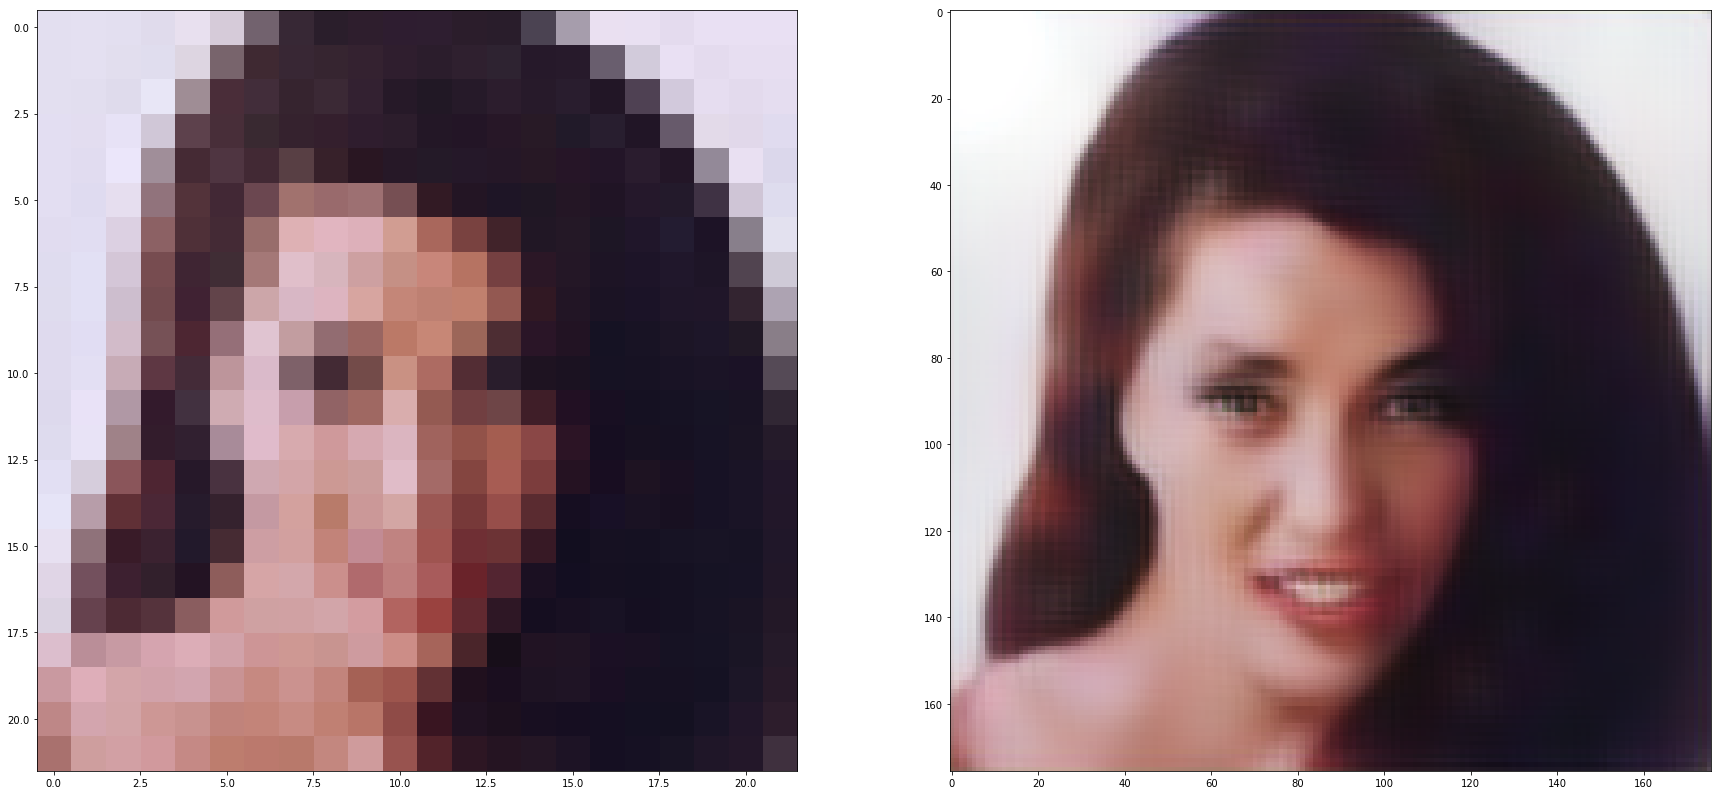

In [27]:
compare_pics(arr_elr[10].astype('uint8'), p[10].astype('uint8'))

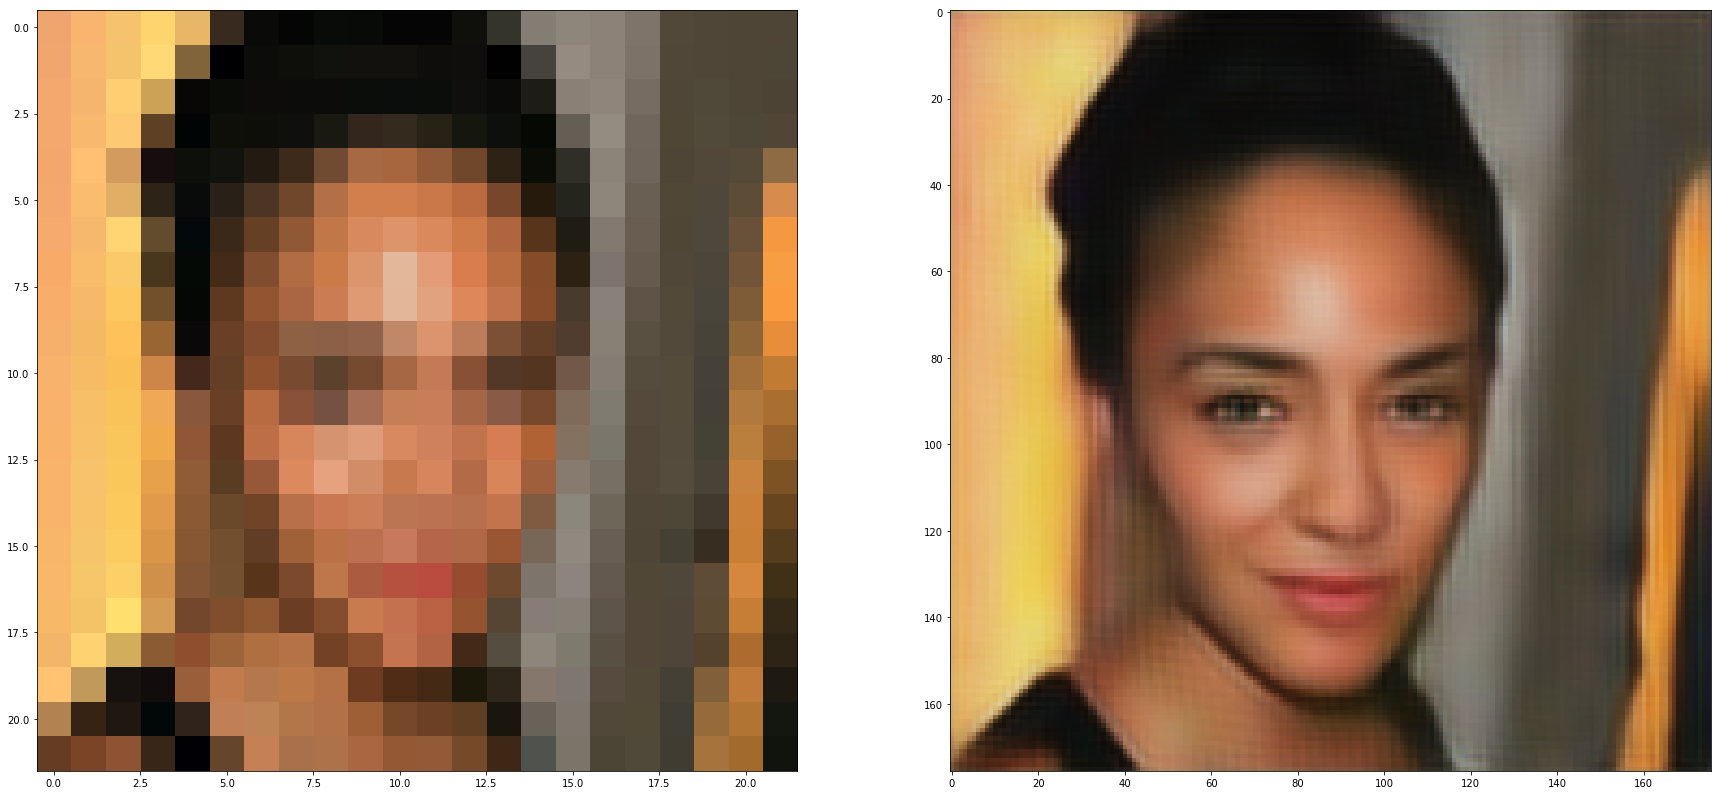

In [32]:
compare_pics(arr_elr[13].astype('uint8'), p[13].astype('uint8'))

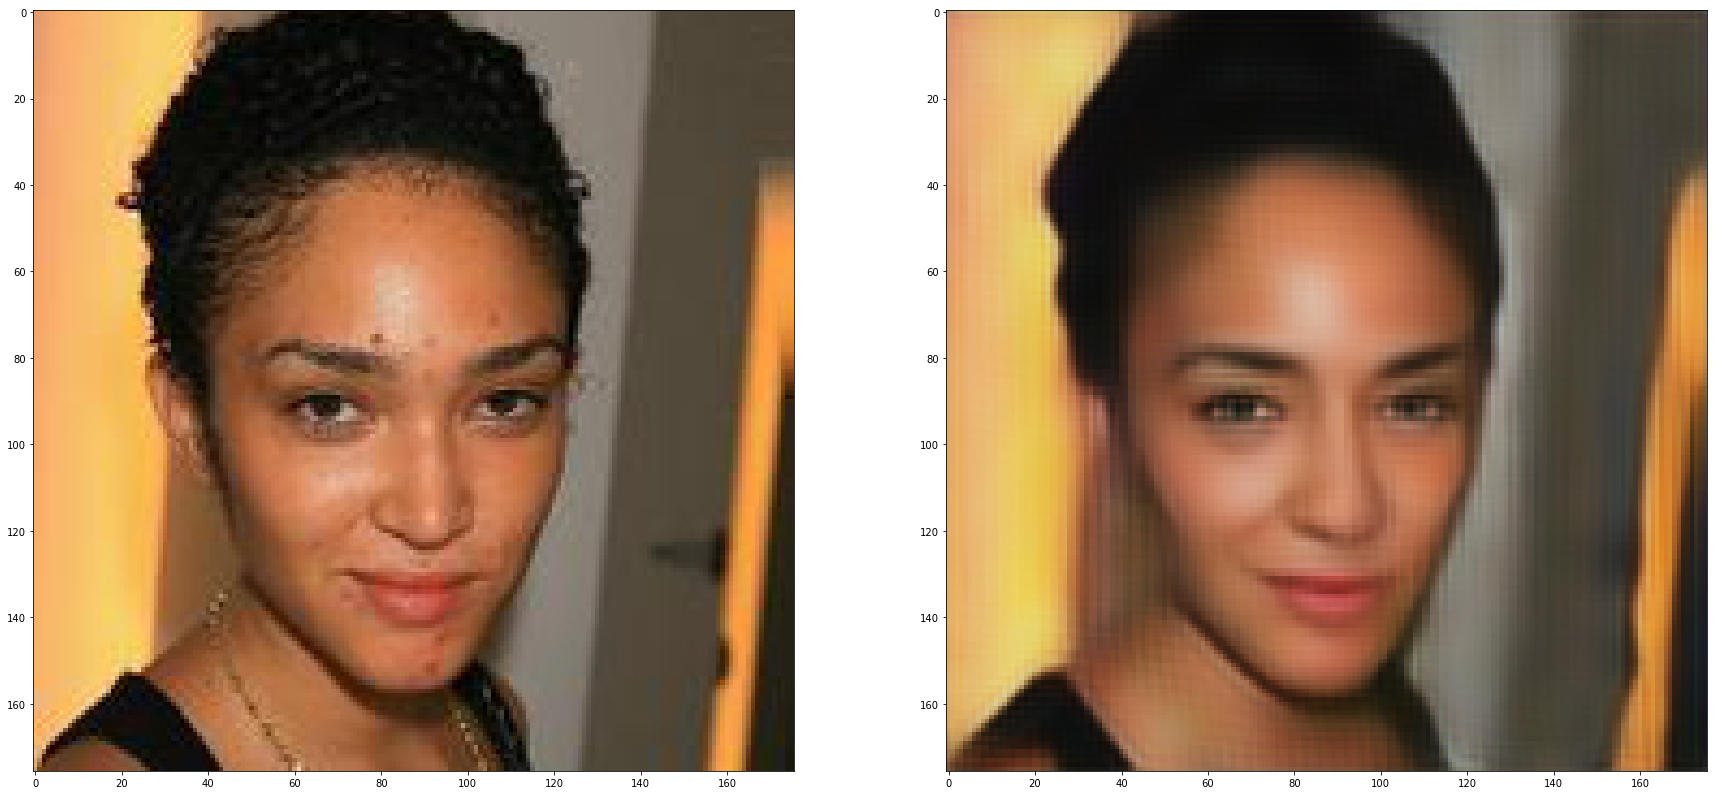

In [33]:
compare_pics(arr_hr[13].astype('uint8'),p[13].astype('uint8'))

# Predicting on Test set that the model hasn't seen

In [34]:
%time p = it_model.predict(arr_test_elr[0:50])
p.shape

CPU times: user 56.7 s, sys: 11.3 s, total: 1min 8s
Wall time: 13.3 s


(50, 176, 176, 3)

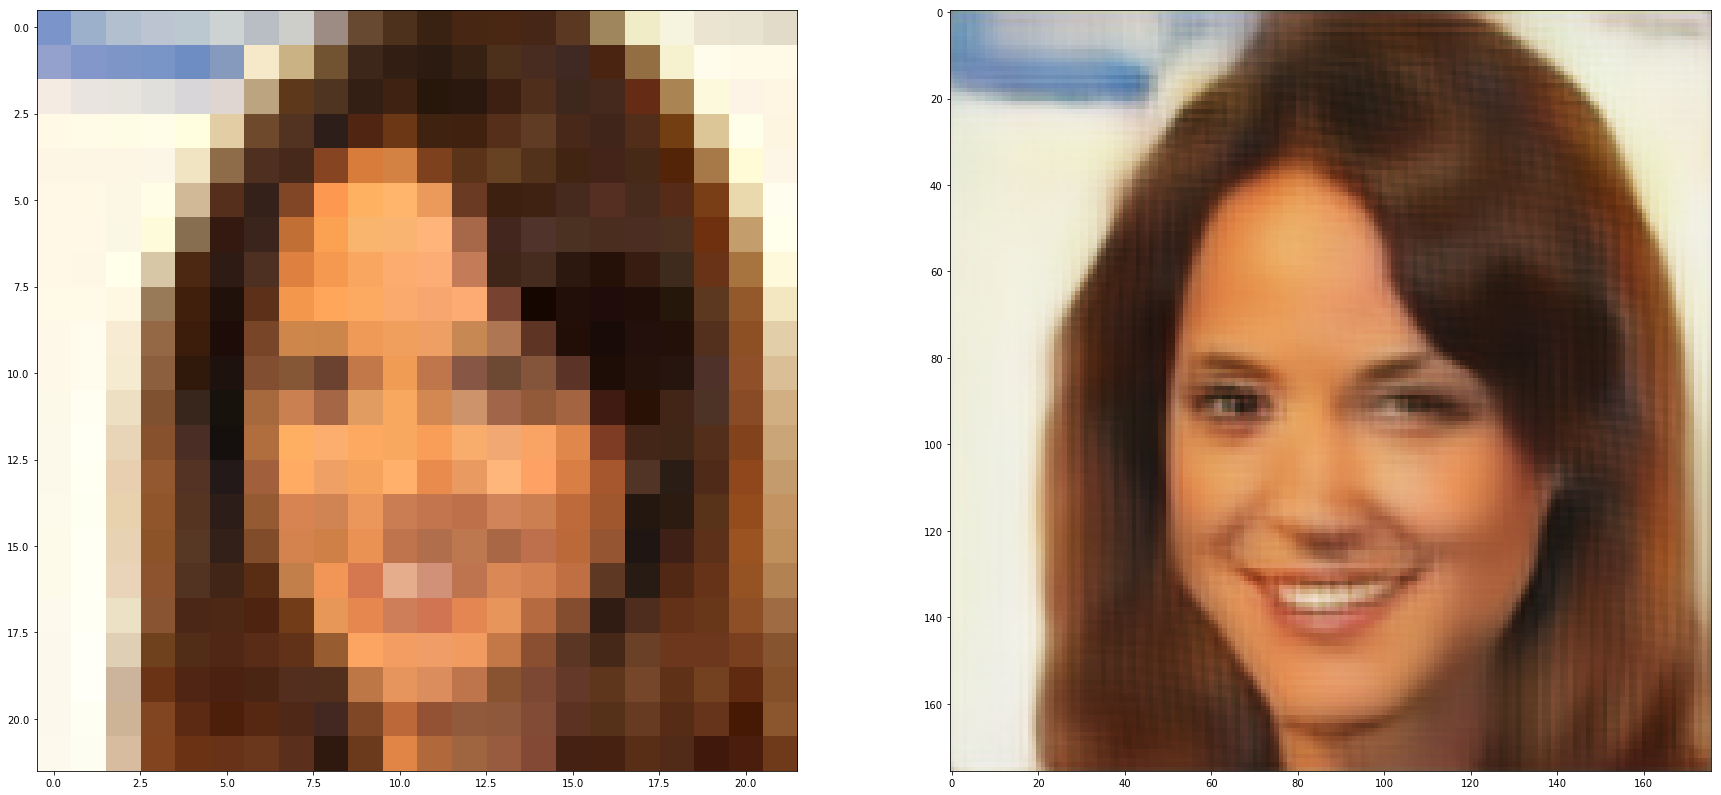

In [35]:
compare_pics(arr_test_elr[24].astype('uint8'),p[24].astype('uint8'))

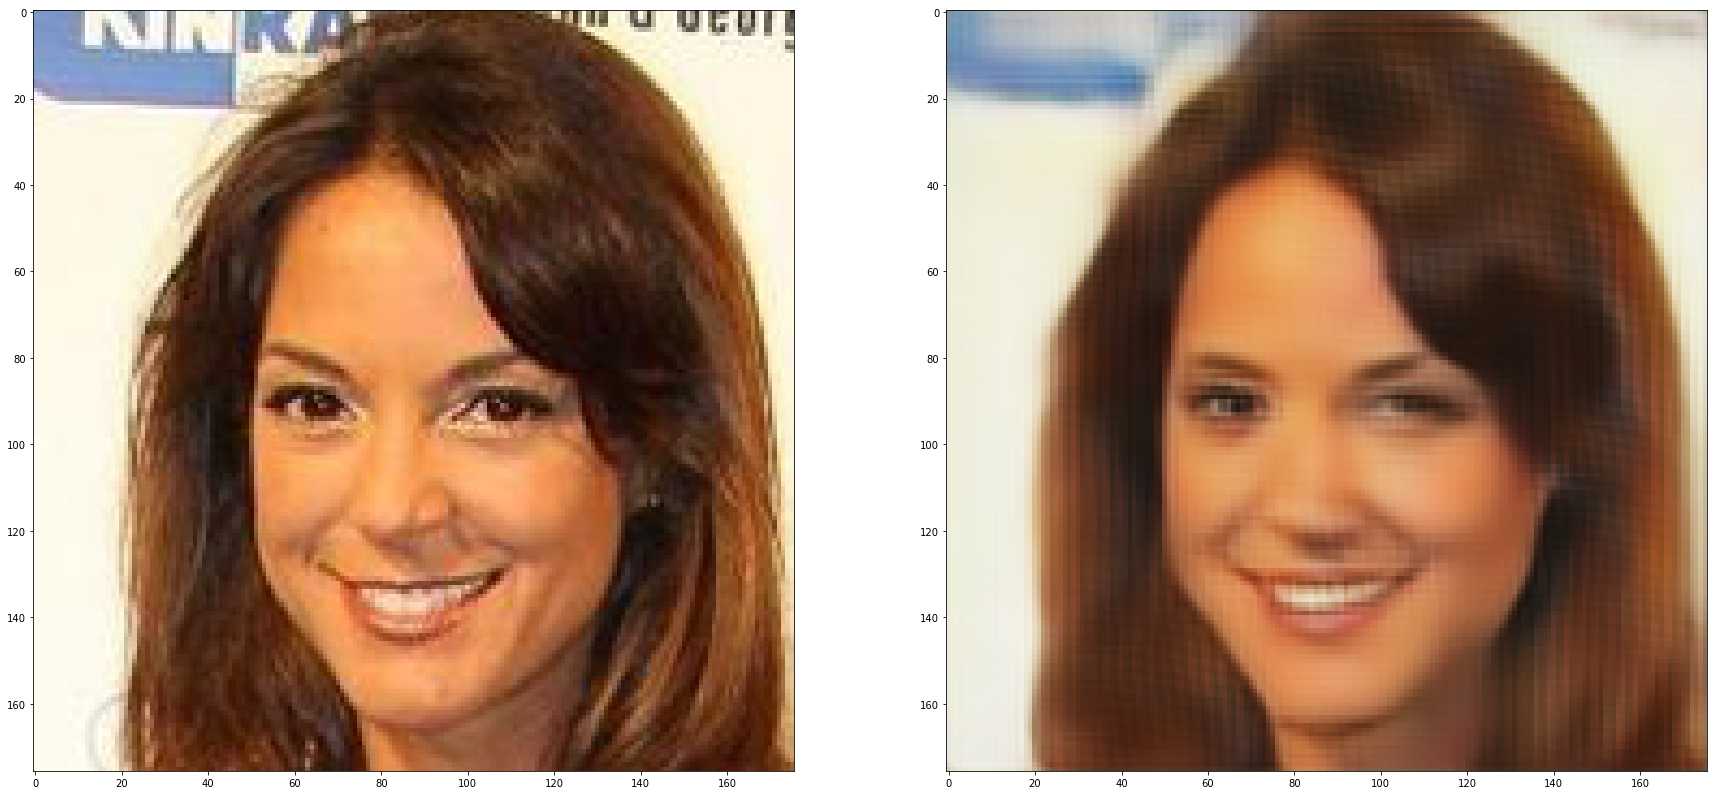

In [45]:
compare_pics(arr_test_hr[24].astype('uint8'),p[24].astype('uint8'))

# Let's Predict on the Prediction or 64x SR

In [46]:
new_upsampled_inp,new_upsampled_output = get_upsampling_model_4x(p[20:25])

In [47]:
new_up_model = Model(new_upsampled_inp,new_upsampled_output)
new_up_model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_5 (InputLayer)             (None, 176, 176, 3)   0                                            
____________________________________________________________________________________________________
convolution2d_40 (Convolution2D) (None, 176, 176, 64)  15616       input_5[0][0]                    
____________________________________________________________________________________________________
batchnormalization_37 (BatchNorm (None, 176, 176, 64)  256         convolution2d_40[0][0]           
____________________________________________________________________________________________________
activation_25 (Activation)       (None, 176, 176, 64)  0           batchnormalization_37[0][0]      
___________________________________________________________________________________________

In [48]:
new_new_up_model = Model(new_upsampled_inp, new_upsampled_output)
new_new_up_model.load_weights('./weights/'+'celba_2k_8x.h5')

In [50]:
%time new_p = new_new_up_model.predict(p[24:25])

CPU times: user 1min 17s, sys: 23.3 s, total: 1min 40s
Wall time: 23.2 s


In [51]:
new_p.shape

(1, 1408, 1408, 3)

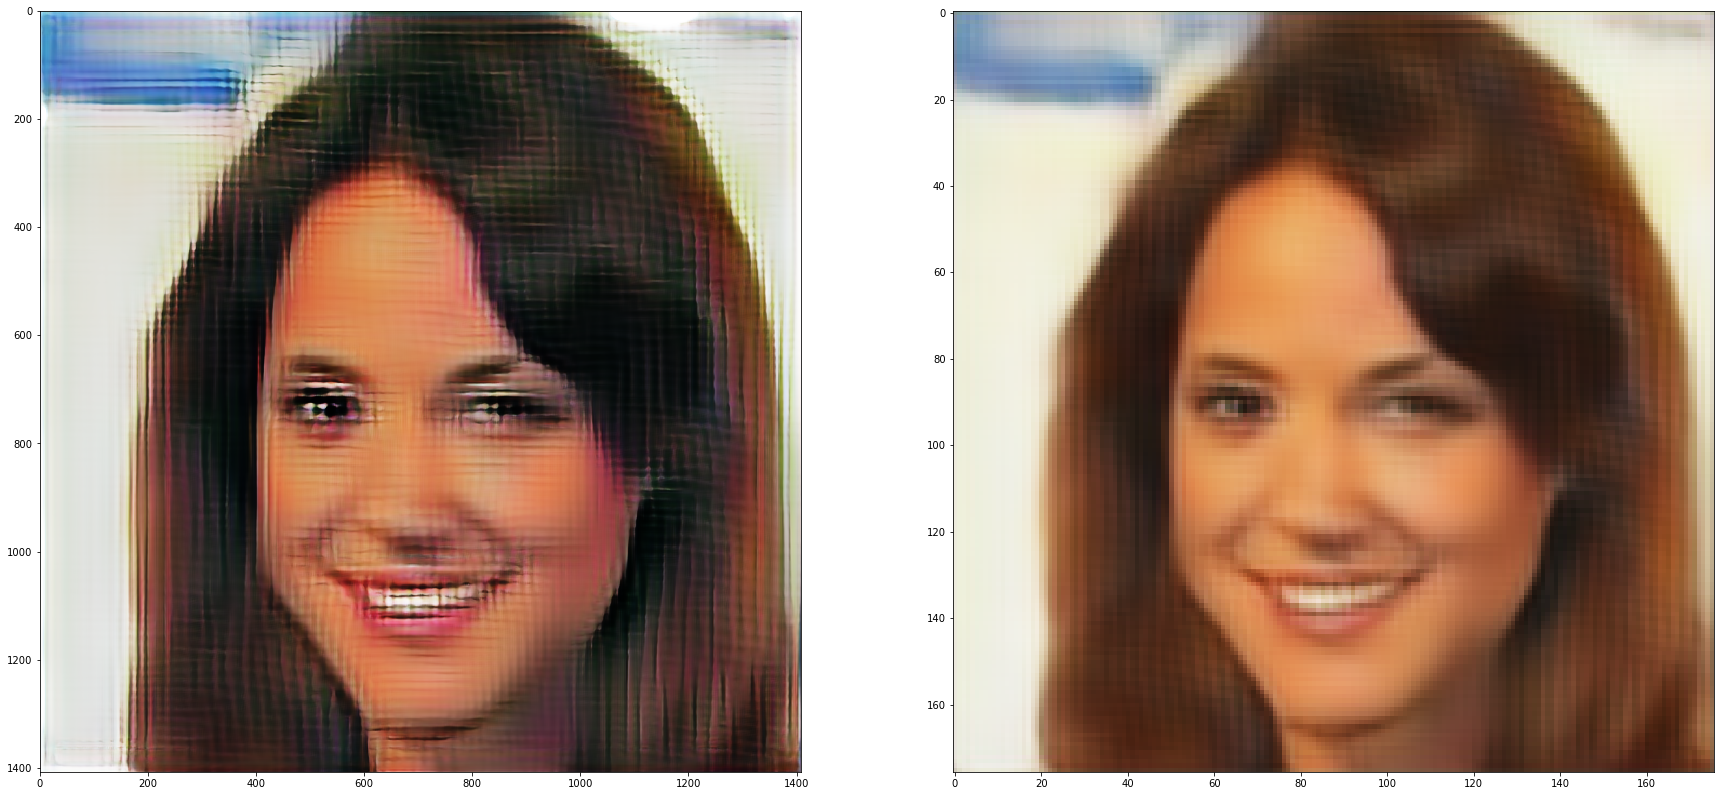

In [52]:
compare_pics(new_p[0].astype('uint8'),p[24].astype('uint8'))

In [ ]:
compare_pics(new_p[4].astype('uint8'),arr_test_hr[24].astype('uint8'))

### Credits

Papers: "Perceptual Losses for Real-Time Style Transfer and Super-Resolution" by Johnson, et.al
http://arxiv.org/abs/1603.08155

"A Neural Algorithm of Artistic Style" by Gatys et.al 
http://arxiv.org/abs/1508.06576v2

Code ideas inspired by Jermey Howard's SFData Institute Advanced Deep Learning Course 